In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D, Flatten, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def batch_generator_fn(X, y, batch_size=32, img_size=256):

    def batch_preproc(X_batch_path, y_batch_label):
        X_batch = []
        batch_size = len(X_batch_path)
#         root = './training_set' # train set path
        root = '/home/jovyan/imagesplace/training_set/' # train set path
        for i in range(batch_size):
            img = cv2.imread(os.path.join(root, X_batch_path[i]), cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
            img = img[:,:,::-1]  # BGR -> RGB
            img = img / 255.
            X_batch.append(img)

        X_batch = np.array(X_batch)
        y_batch = to_categorical(y_batch_label, num_classes=8)

        return X_batch, y_batch
    
    n = len(X)
    num_batch_per_epoch = int(np.ceil(n / batch_size))
    i = 0
    X, y = shuffle(X, y)
    while True:
        start = i * batch_size
        end = np.min([start + batch_size, n])
        X_batch = X[start:end]
        y_batch = y[start:end]
        X_batch, y_batch = batch_preproc(X_batch, y_batch)
            
        yield X_batch, y_batch

        i += 1
        if i == num_batch_per_epoch:
            X, y = shuffle(X, y)
            i = 0

In [4]:
train_df = pd.read_csv('./train_v2.csv')
X = train_df['file'].values
y = train_df['class'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)
batch_size_train = 32
batch_size_valid = 128

image_size = 224

batch_gen_train = batch_generator_fn(X_train, y_train, batch_size_train, image_size)
batch_gen_valid = batch_generator_fn(X_valid, y_valid, batch_size_valid, image_size)

In [5]:
def build_model(img_size):
    inputs = Input(shape=(img_size, img_size, 3))
    
    x = RandomFlip("horizontal")(inputs)
    x = RandomRotation(0.2)(x)
    x = RandomZoom((0., 0.2))(x)
    x = RandomContrast((0., 0.5))(x)
    base_model = NASNetMobile(include_top=False, weights="imagenet")
    x = base_model(x)
    x = Conv2D(32, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)
    
    x = Conv2D(32, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)
    
    x = MaxPool2D((2,2))(x)
    
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(8, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

In [6]:
adam = Adam(learning_rate=1e-5)
model = build_model(image_size)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 224, 224, 3)       0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 32)          304160

In [7]:
def call_list_fun(models, model_name):
    model_dir = './Model/{}-logs'.format(model_name)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    logfiles = model_dir + '/{}-{}'.format('basic_model',
                                           models.__class__.__name__)
    model_cbk = TensorBoard(log_dir=logfiles,
                                            histogram_freq=1)

    modelfiles = model_dir + '/{}-best-model.h5'.format(model_name)
    model_mckp = ModelCheckpoint(modelfiles, monitor='val_accuracy',
                                 save_best_only=True)

    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    return [model_cbk, model_mckp, earlystop]

In [8]:
epochs = 30
len_X_train = len(X_train)
len_X_valid = len(X_valid)
steps_per_epoch = int(np.ceil(len_X_train / batch_size_train))
validation_steps = int(np.ceil(len_X_valid / batch_size_valid))

call_back_list = call_list_fun(model, 'NasNet_model_tuning')

history = model.fit(batch_gen_train, epochs=epochs, 
                                steps_per_epoch=steps_per_epoch,
                                validation_data=batch_gen_valid,
                                validation_steps=validation_steps,
                                callbacks = call_back_list)

Epoch 1/30
3387/3387 [==============================] - 2290s 668ms/step - loss: 2.0220 - accuracy: 0.1960 - val_loss: 1.0352 - val_accuracy: 0.6637
Epoch 2/30
3387/3387 [==============================] - 1040s 307ms/step - loss: 1.2067 - accuracy: 0.5698 - val_loss: 0.7757 - val_accuracy: 0.7401
Epoch 3/30
3387/3387 [==============================] - 1044s 308ms/step - loss: 0.9977 - accuracy: 0.6592 - val_loss: 0.6553 - val_accuracy: 0.7843
Epoch 4/30
3387/3387 [==============================] - 1043s 308ms/step - loss: 0.8833 - accuracy: 0.7056 - val_loss: 0.6097 - val_accuracy: 0.7919
Epoch 5/30
3387/3387 [==============================] - 1049s 310ms/step - loss: 0.8190 - accuracy: 0.7250 - val_loss: 0.5499 - val_accuracy: 0.8097
Epoch 6/30
3387/3387 [==============================] - 1045s 309ms/step - loss: 0.7728 - accuracy: 0.7433 - val_loss: 0.5491 - val_accuracy: 0.8112
Epoch 7/30
3387/3387 [==============================] - 1045s 309ms/step - loss: 0.7363 - accuracy: 0.7526

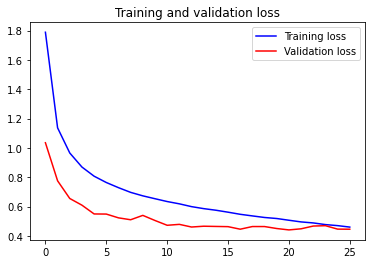

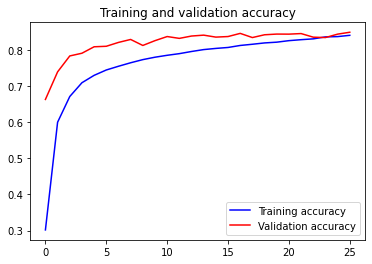

In [9]:
## 畫訓練圖
# 視覺化訓練過程
train_loss = history.history['loss']
train_acc = history.history['accuracy']
test_loss = history.history['val_loss']
test_acc = history.history['val_accuracy']

# 繪製 Training loss 和 Testing loss
plt.plot(train_loss, 'b', label='Training loss')
plt.plot(test_loss, 'r', label='Validation loss')
plt.legend()
plt.title("Training and validation loss")
plt.savefig('image/Training and validation loss.png')
plt.show()

# 繪製 Training accuracy 和 Testing accuracy
plt.plot(train_acc, 'b', label='Training accuracy')
plt.plot(test_acc, 'r', label='Validation accuracy')
plt.legend()
plt.title("Training and validation accuracy")
plt.savefig('image/Training and validation accuracy.png')
plt.show()


In [ ]:
from glob import glob
img_path_list = []
# 路徑要改
for img_path in glob('/home/jovyan/imagesplace/testing_set/*.jpg'):
    img_path_list.append(img_path)

X_test_img = []
X_test_id = []

for path in img_path_list:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (image_size, image_size))
    img = img[:,:,::-1]  # BGR -> RGB
    img = img / 255.
    
    
    img_id = path.split('/')[-1].split('.')[0]
    X_test_img.append(img)
    X_test_id.append(img_id)

X_test_img = np.array(X_test_img, dtype=np.float32)

In [11]:
from tensorflow.keras.models import load_model
# 讀取表現最好的那一次模型
# git_to_AIA/BT102014/Image_Place_Classification/basic_model-best-model.h5
model = load_model('./Model/NasNet_model_tuning-logs/NasNet_model-best-model.h5')
y_pred = model.predict(X_test_img)
y_pred = y_pred.argmax(axis=-1)

In [12]:
submission = pd.DataFrame({'id': X_test_id, 'class': y_pred})

In [13]:
submission.head(10)

,id,class
0,819bc757-baa8-48ac-a103-d081015c2bc6,7
1,b9d21114-50f0-450f-9bf7-06f9f61ab502,5
2,c3e86099-4850-4943-b802-612abb46028a,3
3,6747547c-a95c-4a10-9ab8-bc651d092dbf,3
4,84bab0af-8d09-453e-b047-e5de81f68a99,5
5,1ec05f68-b7e8-44b5-8327-ddb07da3bc61,3
6,e1c236e5-46a6-4dae-be02-d1a1f578ebf7,0
7,46324b46-0e06-4da8-be29-a6033c152a35,6
8,4d959b52-4d5c-4887-9e55-d8bad508eb9a,0
9,db9bc184-3604-414d-8093-d63ad8c48e17,0


In [14]:
# submission.to_csv('./higherline.csv', index=False)
from datetime import datetime
today = datetime.today()
datetime_format = today.strftime("%Y-%m-%d_%H:%M:%S")
submission.to_csv(f'./image_{datetime_format}.csv', index=False)
print('Done!')

Done!
